## Reading Files into Python

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
upload = files.upload()

In [ ]:
train = pd.read_csv('/content/churn_prediction.csv')
data = train.copy()

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Data Science/AV/Churn Prediction/3. Data-Extraction-Collection/churn_prediction.csv')
data = train.copy()

In [4]:
data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction
0,1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2019-05-21
1,2,2348,35,Male,0.0,self_employed,NaN,2,3214,5390.37,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0,2019-11-01
2,4,2194,31,Male,0.0,salaried,146.0,2,41,3913.16,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0,NaT
3,5,2329,90,NaN,NaN,self_employed,1020.0,2,582,2291.91,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2019-08-06
4,6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2019-11-03


In [5]:
data.shape

(28382, 21)

In [6]:
data.isna().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
last_transaction                     0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28382 entries, 0 to 28381
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     28382 non-null  int64  
 1   vintage                         28382 non-null  int64  
 2   age                             28382 non-null  int64  
 3   gender                          27857 non-null  object 
 4   dependents                      25919 non-null  float64
 5   occupation                      28302 non-null  object 
 6   city                            27579 non-null  float64
 7   customer_nw_category            28382 non-null  int64  
 8   branch_code                     28382 non-null  int64  
 9   current_balance                 28382 non-null  float64
 10  previous_month_end_balance      28382 non-null  float64
 11  average_monthly_balance_prevQ   28382 non-null  float64
 12  average_monthly_balance_prevQ2  

In [8]:
data.columns

Index(['customer_id', 'vintage', 'age', 'gender', 'dependents', 'occupation',
       'city', 'customer_nw_category', 'branch_code', 'current_balance',
       'previous_month_end_balance', 'average_monthly_balance_prevQ',
       'average_monthly_balance_prevQ2', 'current_month_credit',
       'previous_month_credit', 'current_month_debit', 'previous_month_debit',
       'current_month_balance', 'previous_month_balance', 'churn',
       'last_transaction'],
      dtype='object')

In [9]:
ID_COL, TARGET_COL = 'customer_id', 'churn'

In [10]:
# non missing data variables
CATEGORICAL = ['customer_nw_category',]
CONTINUOUS = ['vintage', 'age', 'branch_code', 'current_balance',
       'previous_month_end_balance', 'average_monthly_balance_prevQ',
       'average_monthly_balance_prevQ2', 'current_month_credit',
       'previous_month_credit', 'current_month_debit', 'previous_month_debit',
       'current_month_balance', 'previous_month_balance',]

In [11]:
# missing data variables
CATEGORICAL_MISSING = ['gender', 'occupation',]
CONTINUOUS_MISSING = [ 'dependents', 'city',]
DATE_TIME_MISSING = 'last_transaction'

## Validation Criteria For Missing Values

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score

In [24]:
def run_test(data, features):
  '''
  This function runs test on data when its get imputed
  Note :-after imputation and encoding
  '''
  #splitting data train test split
  train, test = train_test_split(data, test_size=0.2, random_state=123, stratify = data[TARGET_COL])
  target = train[TARGET_COL]

  ### Training Set
  X_trn, y_trn = train[features].iloc[:], target.iloc[:]

  ### Test Set
  X_test, y_test = test[features].iloc[:], test[TARGET_COL].iloc[:]

  scaler = StandardScaler()
  _ = scaler.fit(X_trn)

  X_trn = scaler.transform(X_trn)
  X_tst = scaler.transform(X_test)

  # train model
  # clf = DecisionTreeClassifier(random_state=42)
  # clf = RandomForestClassifier()
  clf = SVC()
  _ = clf.fit(X_trn, y_trn)
  preds = clf.predict(X_tst)

  preds_score = f1_score(y_test, preds)
  # print(f'\nf1 score for test is {preds_score}')

  return preds_score

# Missing Value Treatment

In [25]:
def Automate_imputation(data, cat_missing, cont_missing, skip_var=None):

  # possible operation on categorical variable
  CAT_OPERATION = ['Mode', 'NAN feature(Mode)', 'Const']
  # possible operation on continuous variable
  CONT_OPERATION = ['Mean', 'Median', 'Mode', 'NAN feature(Mean)', 'NAN feature(Median)', 'NAN feature(Mode)',]

  #dataframe
  df_acc = pd.DataFrame(columns=['Combination', 'Accuracy'])

  # drop na
  df = data.copy()
  df = df.dropna()
  df = pd.get_dummies(df, columns=cat_missing, drop_first=True)

  # check accuracy
  features = [c for c in df.columns if c not in skip_var]
  acc = run_test(df, features)

  # add combination to dataframe
  df_acc = df_acc.append({'Combination': 'Drop Null', 'Accuracy' : acc}, ignore_index=True)

  for cat_op in CAT_OPERATION:
    for cont_op in CONT_OPERATION:

      # dummy dataframe
      df = data.copy()

      # drop unwanted variables
      df = df.drop(labels=skip_var, axis=1,)

      # categorical operation
      if cat_op == 'Mode':
        for i in cat_missing:
          impute_mode(df, i)
      elif cat_op == 'NAN feature(Mode)':
        for i in cat_missing:
          impute_nan(df, i)
          impute_mode(df, i)
      elif cat_op == 'Const':
        for i in cat_missing:
          impute_const(df, i, 'Missing')

      df = pd.get_dummies(df, columns=cat_missing, drop_first=True)

      # continuous operation
      if cont_op == 'Mean':
        for i in cont_missing:
          impute_mean(df, i)
      elif cont_op == 'Median':
        for i in cont_missing:
          impute_median(df, i)
      elif cont_op == 'Mode':
        for i in cont_missing:
          impute_mode(df, i)
      elif cont_op == 'NAN feature(Mean)':
        for i in cont_missing:
          impute_nan(df, i)
          impute_mean(df, i)
      elif cont_op == 'NAN feature(Median)':
        for i in cont_missing:
          impute_nan(df, i)
          impute_median(df, i)
      elif cont_op == 'NAN feature(Mode)':
        for i in cont_missing:
          impute_nan(df, i)
          impute_mode(df, i)
      elif cont_op == 'Const':
        for i in cont_missing:
          impute_const(df, i, 0)

      # check accuracy
      features = [c for c in df.columns if c not in skip_var]
      acc = run_test(df, features)

      # add combination to dataframe
      df_acc = df_acc.append({'Combination': cat_op+'/'+cont_op, 'Accuracy' : acc}, ignore_index=True)

  # visualize data
  plt.figure(figsize=(20,6))
  x = df_acc['Combination']
  y = df_acc['Accuracy']
  plt.plot(x, y)
  plt.grid(True)
  plt.title('ML model : SVM')
  plt.xlabel('imputation methods', fontsize=15)
  plt.ylabel('F1 scores', fontsize=15)
  plt.xticks(rotation=90)
  plt.show()

## **1. Deleting Missing Records**

In [26]:
# deleting row with missing values
df = data.dropna()

## **2. Mean, Median & Mode**

In [27]:
# mean imputation
def impute_mean(df, variable):
  mean = df[variable].mean()
  df[variable] = df[variable].fillna(mean)

# median imputation
def impute_median(df, variable):
  median = df[variable].median()
  df[variable] = df[variable].fillna(median)

# mode imputation
def impute_mode(df, variable):
  mode = df[variable].mode()[0]
  df[variable] = df[variable].fillna(mode)

## **3. NaN Capturing with new variable**

In [28]:
def impute_nan(df, variable):
  df[variable+'_NAN'] = np.where(df[variable].isnull(), 1, 0)

## **4. End of Distribution**

## **5. Arbitrary Distribution**

In [29]:
# arbitrary imputation
def impute_const(df, variable, const):
  df[variable] = df[variable].fillna(const)

# Automatic Imputation (Comprise above methods)

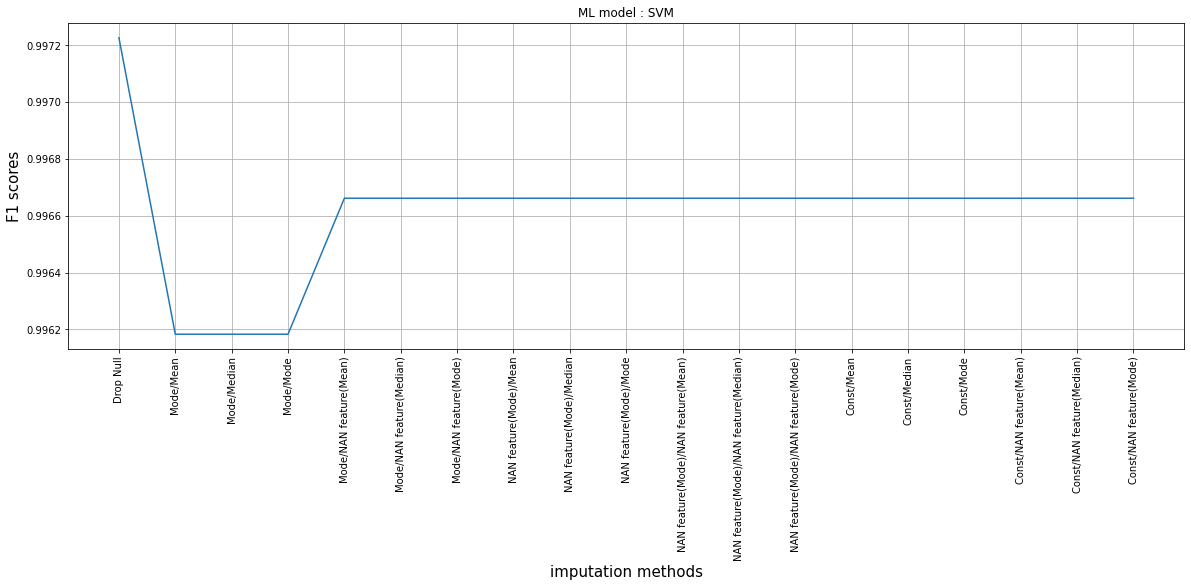

In [30]:
Automate_imputation(data=data, cat_missing=CATEGORICAL_MISSING, cont_missing=CONTINUOUS_MISSING, skip_var=DATE_TIME_MISSING)

## **6. Random sample**

In [31]:
def impute_rand_sample(df, variable, random_state):
  # previous data coping
  # df[variable+'_random'] = df[variable]
  # random sample collecting
  random_sample = df[variable].dropna().sample(df[variable].isnull().sum(), random_state=random_state)
  # eqvating indexes of random and null values
  random_sample.index = df[df[variable].isnull()].index
  # add values to their respective locations
  df.loc[ df[variable].isnull(), variable] = random_sample

In [32]:
def Random_imputation(data, cat_missing, cont_missing, skip_var=None, N=100):
  #dataframe
  df_acc = pd.DataFrame(columns=['Combination', 'Accuracy'])
  random = N
  for i in range(random):
    df = data.copy()
    for cat_var in cat_missing:
      impute_rand_sample(df, cat_var, i)
    for cont_var in cont_missing:
      impute_rand_sample(df, cont_var, i)
    df = pd.get_dummies(df, columns=cat_missing, drop_first=True)
    features = [c for c in df.columns if c not in skip_var]
    pred_acc = run_test(df, features)

    # add combination to dataframe
    df_acc = df_acc.append({'Combination': i, 'Accuracy' : pred_acc}, ignore_index=True)

  # visualize data
  plt.figure(figsize=(21,6))
  x = df_acc['Combination']
  y = df_acc['Accuracy']
  plt.plot(x, y)
  plt.grid(True)
  plt.title('ML model : SVM')
  plt.xlabel('random state', fontsize=15)
  plt.ylabel('F1 scores', fontsize=15)
  # plt.xticks(rotation=90)
  plt.show()

## Results:

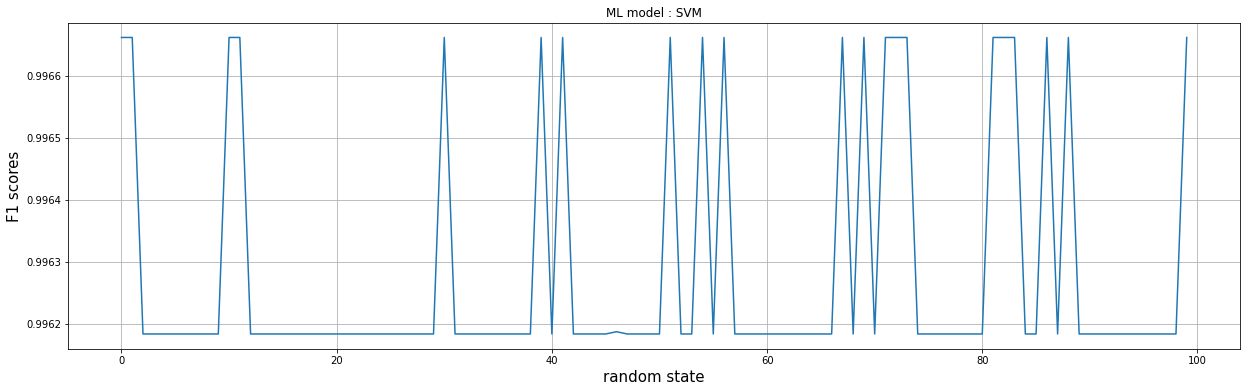

In [33]:
Random_imputation(data=data, cat_missing=CATEGORICAL_MISSING, cont_missing=CONTINUOUS_MISSING, skip_var=DATE_TIME_MISSING)

## **7. KNN Imputation**

In [34]:
class KNN_Imputation:

  def __init__(self, data, cat_vr, skip_var):
    '''
    data : data frame
    skip_var : variables to skip from dataframe at the time of training
    '''
    features = [c for c in data.columns if c not in skip_var]
    self.df =  data[features].copy()
    self.cat_var = cat_var

  def encode(self, df, cols):
    '''Label encoder'''
    for i in cols:
      le = LabelEncoder()
      df[i] = le.fit_transform(df[i])

  def Plot(self, df_acc, target, ylabel):
    '''Visualizing the results'''
    try:
      # visualize data
      plt.figure(figsize=(21,6))
      x = df_acc['Combination']
      y = df_acc['Accuracy']
      plt.plot(x, y)
      plt.grid(True)
      plt.title('ML model : KNN for '+target, fontsize=15)
      plt.xlabel('Neighbores', fontsize=15)
      plt.ylabel(ylabel , fontsize=15)
      # plt.xticks(rotation=90)
      plt.show()
    except Exception as ex:
      print(ex)

  def Random_imputation(self, CAT_MISSING, CONT_MISSING, N=10, TYPE='CAT'):
    try:
      # select type of imputation
      if TYPE == 'CAT':
        missing_var = CAT_MISSING
        df = self.df.drop(CONT_MISSING, axis=1)
        ylabel = 'F1 score'
      elif TYPE == 'CONT':
        missing_var = CONT_MISSING
        df = self.df.drop(CAT_MISSING, axis=1)
        ylabel = 'RMSE'

      # all features except missing var
      df = pd.get_dummies(df, columns=self.cat_var, drop_first=True)
      
      for i in missing_var:
        features = [c for c in df.columns if c not in missing_var]
        TRAIN =  df[~df[i].isna()] # non missing rows
        #seperating independent and dependent variables
        x = TRAIN[features]
        self.encode(TRAIN, [i])
        y = TRAIN[i]
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        x_scaled = scaler.fit_transform(x)

        x = pd.DataFrame(x_scaled)

        #splitting data train test split
        train_x,test_x,train_y,test_y = train_test_split(x, y, test_size=0.2, random_state=123)#, stratify = y)
        #dataframe
        df_acc = pd.DataFrame(columns=['Combination', 'Accuracy'])

        for j in range(1,N):
          if TYPE =='CAT':
            # Creating instance of KNN
            clf = KNeighborsClassifier(n_neighbors = j)
            clf = KNeighborsRegressor(n_neighbors = j)
            clf.fit(train_x, train_y)
            test_predict = clf.predict(test_x)
            k = accuracy_score(test_predict, test_y)
          
          elif TYPE == 'CONT':
            clf = KNeighborsRegressor(n_neighbors = j)
            clf.fit(train_x, train_y)
            test_predict = clf.predict(test_x)
            k = np.sqrt(mean_squared_error(test_predict, test_y))
          
          df_acc = df_acc.append({'Combination': j, 'Accuracy' : k}, ignore_index=True)
        self.Plot(df_acc, i, ylabel)
    except Exception as ex:
      raise ex

## Results:

In [35]:
KNN = KNN_Imputation(data, CATEGORICAL, [ID_COL, DATE_TIME_MISSING])

NameError: ignored

In [ ]:
KNN.Random_imputation(CATEGORICAL_MISSING, CONTINUOUS_MISSING, N=100, TYPE='CONT')

In [ ]:
KNN.Random_imputation(CATEGORICAL_MISSING, CONTINUOUS_MISSING, N=100, TYPE='CAT')

**Conclusion:**
- Droping Null is best option, though we lossing some information as well as data.

In [ ]:
df = data.dropna()
file_name = 'churn_prediction-clean_phase-1.csv' 
df.to_csv(file_name)

In [ ]:
from google.colab import files
files.download(file_name) 